# Sumo Bouts Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
from datetime import datetime
import os
import glob
from random import random




import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
tournaments = ['hatsu', 'haru', 'natsu', 'nagoya', 'aki', 'kyushu']
divisions = ['Makuuchi', 'Juryo', 'Makushita' 'Sandanme', 'Jonidan', 'Jonokuchi']
# The top-division (Makuuchi) has many levels: Y, O, S, K & M
div_codes = {'Y':1, 'O':2, 'S':3, 'K':4, 'M':5, 'J':6, 'Ms':7, 'Sd':8, 'Jd':9, 'Jk':10}


In [3]:
def parse_rank(code):
    '''
    given a rank code like M12e, separate the division (M),
    rank (12) and side (e or w)
    '''
    pattern = r"^([A-Za-z]{1,2})(\d+)([ew]{1})$"

    match = re.match(pattern, code)
    if match:
        division = match.group(1)
        rank = int(match.group(2))
        side = int(match.group(3) == 'e')
        # print("division = %s, rank = %d\n"%(division, rank))
        if division in div_codes:
            return (div_codes[division], rank, side)
    
    return (None,None,None)

    
def calculate_age(dob):
    '''
    Given a date of birth (e.g. 03.07.1986), return age
    '''
    current_date = datetime.now()
    try:
        birth_date = datetime.strptime(dob, '%d.%m.%Y')

        days_difference = (current_date - birth_date).days
        age = round(days_difference / 365, 2)
        return age
    
    except BaseException:
        # dob not in the correct format
        raise ValueError("Incorrect date of birth")

        
def list_text_files(directory):
    '''
    list all the text files in a directory
    '''
    # Create the file path pattern to match text files
    file_pattern = os.path.join(directory, "*.txt")

    # Use glob to find all matching file paths
    text_files = glob.glob(file_pattern)

    return text_files


In [4]:
parse_rank('M12w')

(5, 12, 0)

In [5]:
dob = '03.07.1986'
age = calculate_age(dob)
print(age)


37.17


In [6]:
len(list_text_files('/Users/saumyaranjanpanigrahi/Desktop/Dissertation/Data Set/datasumo/torikumi/2020/'))

79

## Load the Datasets
The ranking information is available in the 'Banzuke' folder. It also has the name, D.O.B, height, weight, stable (training team/gym) & place of the wrestler.

The bouts info is present in the 'Torikumi' folder. Each row list two players (their ranks, names, fighting record) & the winning technique. The winning wrestler is always listed first!

We have to merge both the datasets (banzuke & torikumi) to create our final dataset!

In [7]:
# the root directory of the dataset 
root_dir = '/Users/saumyaranjanpanigrahi/Desktop/Dissertation/Data Set/datasumo'


In [8]:
def merge_info(p1, p2, label):
    '''
    merge the info of two wrestlers.
    p1 & p2 are two dictionaries
    label is 1 is p1 wins & 0 if p1 loses
    '''
    p = {
        'p1_division': p1['division'],
        'p1_rank_in_division': p1['rank_in_division'],
        'p1_eside': p1['eside'],
        'p1_name': p1['name'],
        'p1_place': p1['place'],
        'p1_stable': p1['stable'],
        'p1_age': p1['age'],
        'p1_height': p1['height'],
        'p1_weight': p1['weight'],
        'p1_streak': p1['streak'],
        'p2_division': p2['division'],
        'p2_rank_in_division': p2['rank_in_division'],
        'p2_eside': p2['eside'],
        'p2_name': p2['name'],
        'p2_place': p2['place'],
        'p2_stable': p2['stable'],
        'p2_age': p2['age'],
        'p2_height': p2['height'],
        'p2_weight': p2['weight'],
        'p2_streak': p2['streak'],
        'p1_won': label
    }
    
    return p


In [9]:
# list of all bouts
bouts_data = []

# consider years from 2002 to 2023
for current_year in range(2002, 2024):

    # the rank list (banzuke) for the current year
    banzuke = {}

    # read the current year banzuke (ranking) for various tournaments
    for idx, venue in enumerate(tournaments):
        month = 2*idx + 1
        file_path = os.path.join(root_dir, 'banzuke', str(current_year),
                                str(current_year) + '_' + str(month).zfill(2) + '_' + venue + '.txt')

        # check whether the file exists
        if not os.path.exists(file_path): continue

        # read the contents of the banzuke file
        with open(file_path) as fin:
            # map a wrestler rank to their age, height, weight etc. 
            wrestler_info = {}

            for line in fin:
                # check for mal-formatted lines & header lines
                if len(line.split()) != 7: continue

                # split the lines into 7 values
                (code, name, place, stable, 
                     dob, height, weight) = line.strip().split()

                # split the code (first column) into division, rank & side
                (div, rank_in_div, e_side) = parse_rank(code)

                # skip if invalid rank
                if div is None: continue

                # watch out for ValueError when converting string to integers
                age = None
                try:
                    # convert dob to age
                    age = calculate_age(dob)

                    # convert height & weight to integers
                    height = int(height)
                    weight = int(weight)

                except ValueError:
                    # ignore this line & move to next 
                    continue

                wrestler_info[code] = {
                    'division': div,
                    'rank_in_division': rank_in_div,
                    'eside': e_side,
                    'name': name,
                    'place': place,
                    'stable': stable,
                    'age': age,
                    'height': height,
                    'weight': weight,
                }

            # keep rank list of wrestlers in each tournament
            banzuke[venue] = wrestler_info

            
    # Read Torikumi files once the Banzuke is read for the current year
    torikumi_dir_path = os.path.join(root_dir, 'torikumi', str(current_year))

    # for each file in the directory for the current year
    for torikumi_file in list_text_files(torikumi_dir_path):
        # read the file
        with open(torikumi_file) as fin:  

            # get the venue from the file name
            venue = torikumi_file.split('_')[2].strip()

            for line in fin:
                # check for mal-formatted lines & header lines
                if len(line.split()) != 7: continue

                # split the lines into 7 values
                (p1_code, p1_name, p1_streak, submission, 
                     p2_code, p2_name, p2_streak) = line.strip().split()

                p1 = banzuke[venue].get(p1_code)
                p2 = banzuke[venue].get(p2_code)

                # make sure both p1 & p2 are present in banzuke
                if (p1 is None or p2 is None): continue
                    
                # make sure both p1 & p2 are from the top division 
                if p1['division'] > 5 or p2['division'] > 5: continue
                
                # Add streak info to both p1 & p2
                p1['streak'] = eval(p1_streak) - 1
                p2['streak'] = eval(p2_streak) + 1
                
                # p1 beats p2; but let's change the order half of the time 
                # this ensures a balanced two class dataset.
                if random() < 0.5:
                    bouts_data.append(merge_info(p1, p2, 1))
                else:
                    bouts_data.append(merge_info(p2, p1, 0))




In [10]:
# convert into a dataframe
df = pd.DataFrame(bouts_data)

# save to a csv file
out_file = os.path.join(root_dir, 'sumo_bouts_data.csv')
df.to_csv(out_file, index=False)


## Prepare the Dataset

Removing unwanted columns & perform train-test splitting.



In [11]:
# read the dataset
df = pd.read_csv(out_file)
df.head(10)


,p1_division,p1_rank_in_division,p1_eside,p1_name,p1_place,p1_stable,p1_age,p1_height,p1_weight,p1_streak,...,p2_rank_in_division,p2_eside,p2_name,p2_place,p2_stable,p2_age,p2_height,p2_weight,p2_streak,p1_won
0,5,10,0,Chiyotenzan,Osaka,Kokonoe,47.58,184,142,-5,...,15,0,Asanowaka,Aichi,Takasago,53.74,176,136,-1,1
1,5,13,1,Oikari,Kyoto,Isenoumi,51.22,176,133,-1,...,7,1,Otsukasa,Hyogo,Irumagawa,52.55,174,147,-1,0
2,5,7,0,Wakanoyama,Wakayama,Musashigawa,51.32,177,160,-1,...,12,1,Hamanishiki,Kumamoto,Oitekaze,46.78,181,126,-3,0
3,5,4,1,Daizen,Osaka,Nishonoseki,58.73,188,156,-5,...,5,0,Tamakasuga,Ehime,Kataonami,51.66,183,151,-5,0
4,5,4,1,Takamisakari,Aomori,Azumazeki,47.32,189,134,0,...,7,1,Toki,Chiba,Takasago,49.17,190,174,0,1
5,5,3,0,Tamanoshima,Fukushima,Kataonami,45.97,188,149,-2,...,6,0,Kotoryu,Hyogo,Sadogatake,51.51,183,143,-2,0
6,5,3,1,Tamakasuga,Ehime,Kataonami,51.66,183,151,-2,...,1,1,Musashimaru,U.S.A.,Musashigawa,52.35,192,227,2,0
7,5,15,0,Asanowaka,Aichi,Takasago,53.74,176,136,-1,...,12,1,Hamanishiki,Kumamoto,Oitekaze,46.78,181,126,1,1
8,5,12,0,Buyuzan,Aichi,Musashigawa,49.10,181,160,1,...,11,0,Tamanoshima,Fukushima,Kataonami,45.97,188,149,1,0
9,5,7,1,Otsukasa,Hyogo,Irumagawa,52.55,174,147,-3,...,8,1,Kotoryu,Hyogo,Sadogatake,51.51,183,143,1,1


In [12]:
# let's keep only numeric columns.
df.drop(columns=['p1_name', 'p1_place', 'p1_stable',
              'p2_name', 'p2_place', 'p2_stable'], axis=1, inplace=True)


df.head()


,p1_division,p1_rank_in_division,p1_eside,p1_age,p1_height,p1_weight,p1_streak,p2_division,p2_rank_in_division,p2_eside,p2_age,p2_height,p2_weight,p2_streak,p1_won
0,5,10,0,47.58,184,142,-5,5,15,0,53.74,176,136,-1,1
1,5,13,1,51.22,176,133,-1,5,7,1,52.55,174,147,-1,0
2,5,7,0,51.32,177,160,-1,5,12,1,46.78,181,126,-3,0
3,5,4,1,58.73,188,156,-5,5,5,0,51.66,183,151,-5,0
4,5,4,1,47.32,189,134,0,5,7,1,49.17,190,174,0,1


### Normalize Data
Dividing each column by the maximum magnitue of its values

In [13]:
df_max_values = np.max(df, axis=0)
df_max_values


p1_division              5.00
p1_rank_in_division     18.00
p1_eside                 1.00
p1_age                  58.73
p1_height              203.00
p1_weight              227.00
p1_streak               14.00
p2_division              5.00
p2_rank_in_division     18.00
p2_eside                 1.00
p2_age                  58.73
p2_height              203.00
p2_weight              227.00
p2_streak               14.00
p1_won                   1.00
dtype: float64

In [14]:
df_norm = df.div(df_max_values, axis=1)
df_norm.head()


,p1_division,p1_rank_in_division,p1_eside,p1_age,p1_height,p1_weight,p1_streak,p2_division,p2_rank_in_division,p2_eside,p2_age,p2_height,p2_weight,p2_streak,p1_won
0,1.0,0.555556,0.0,0.810148,0.906404,0.625551,-0.357143,1.0,0.833333,0.0,0.915035,0.866995,0.599119,-0.071429,1.0
1,1.0,0.722222,1.0,0.872127,0.866995,0.585903,-0.071429,1.0,0.388889,1.0,0.894773,0.857143,0.647577,-0.071429,0.0
2,1.0,0.388889,0.0,0.873829,0.871921,0.704846,-0.071429,1.0,0.666667,1.0,0.796526,0.891626,0.555066,-0.214286,0.0
3,1.0,0.222222,1.0,1.000000,0.926108,0.687225,-0.357143,1.0,0.277778,0.0,0.879619,0.901478,0.665198,-0.357143,0.0
4,1.0,0.222222,1.0,0.805721,0.931034,0.590308,0.000000,1.0,0.388889,1.0,0.837221,0.935961,0.766520,0.000000,1.0


### Split into Train Test Sets 
Use a 80%-20% split.

The datasets are almost perfectly balanced as can be seen in the below plots.

In [15]:
from sklearn.model_selection import train_test_split


In [16]:
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=42)

print('Number of rows in the train data = {}'.format(df_train.shape[0]))
print('Number of rows in the test data = {}'.format(df_test.shape[0]))


Number of rows in the train data = 7100
Number of rows in the test data = 1775


[]

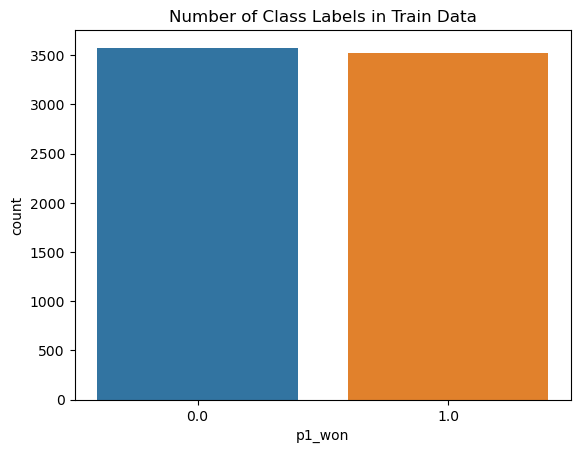

In [17]:
# plot train data labels
sns.countplot(x=df_train['p1_won'])
plt.title('Number of Class Labels in Train Data')
plt.plot()


[]

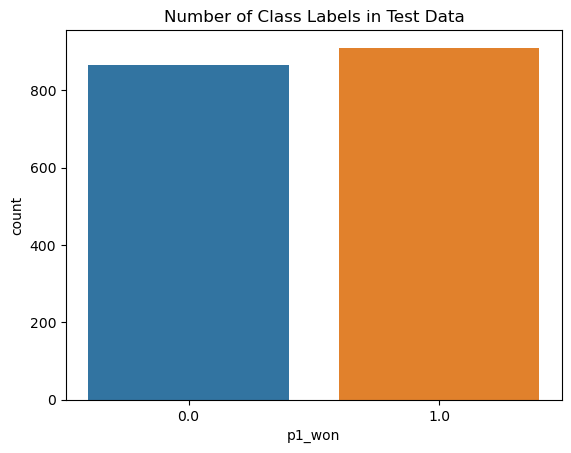

In [18]:
# plot test data labels
sns.countplot(x=df_test['p1_won'])
plt.title('Number of Class Labels in Test Data')
plt.plot()


## Baseline Model

Make predictions based on the rank of the player only! Measure accuracy using this model.

**Strategy**: *The higher ranked wrestler always wins!*

In [19]:
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [20]:
def compare_ranks(division1, rank1, eside1, 
                 division2, rank2, eside2):
    '''
    if the player1 has higher rank than player2 return True
    else return False
    '''
    if division1 < division2:
        return True
    
    if division2 < division1:
        return False
    
    # if same division
    if rank1 < rank2:
        return True
    
    if rank2 < rank1:
        return False
    
    # if same rank as well
    # side 'e' is higher ranked than 'w'
    return (eside1 > eside2)


In [21]:
# Measure Train set Accuracy
correct, total = 0, 0

for idx, row in df_train.iterrows():
    prediction = compare_ranks(row['p1_division'],
                               row['p1_rank_in_division'],
                               row['p1_eside'],
                               row['p2_division'],
                               row['p2_rank_in_division'],
                               row['p2_eside']
                              )
    
    actual = row['p1_won']
    
    if prediction == actual:
        correct += 1
    
    total += 1

baseline_acc_train = correct/total
print("Baseline Train set Accuracy = %.3f%%" % (baseline_acc_train*100))


Baseline Train set Accuracy = 57.873%


In [22]:
# Measure Test set Accuracy
correct, total = 0, 0

for idx, row in df_test.iterrows():
    prediction = compare_ranks(row['p1_division'],
                               row['p1_rank_in_division'],
                               row['p1_eside'],
                               row['p2_division'],
                               row['p2_rank_in_division'],
                               row['p2_eside']
                              )
    
    actual = row['p1_won']
    
    if prediction == actual:
        correct += 1
    
    total += 1

baseline_acc_test = correct/total
print("Baseline Test set Accuracy = %.3f%%" % (baseline_acc_test*100))


Baseline Test set Accuracy = 56.394%


## Logistic Regression Model

Train a logistic regression model

In [23]:
from sklearn.linear_model import LogisticRegression


In [24]:
# split into features & labels
X_train = df_train.iloc[:, :-1] # select all columns except the last one
y_train = df_train.iloc[:, -1]  # select the last column


# train the classifier using the full training data
log_clf = LogisticRegression(random_state=0, max_iter=500)
log_clf.fit(X_train, y_train)


LogisticRegression(max_iter=500, random_state=0)

In [25]:
# measure accuracy of the train set
predictions = log_clf.predict(X_train)
log_acc_train = sum(predictions == y_train)/len(predictions)
print("Logistic Regression Accuracy on the Train data:  = %.2f%%" % (log_acc_train*100))


Logistic Regression Accuracy on the Train data:  = 59.52%


In [26]:
# make predictions on the test set
X_test = df_test.iloc[:, :-1] # select all columns except the last one
y_test = df_test.iloc[:, -1]  # select the last column

# measure accuracy of the test set
predictions = log_clf.predict(X_test)
log_acc_test = sum(predictions == y_test)/len(predictions)
print("Logistic Regression Accuracy on the Test se = %.2f%%" % (log_acc_test*100))


Logistic Regression Accuracy on the Test se = 58.65%


### 10-fold Cross Validation
We will perform a 10-fold cross validation using the full data.

In [27]:
# split into features & labels
X = df_norm.iloc[:, :-1] # select all columns except the last one
y = df_norm.iloc[:, -1]  # select the last column



In [28]:
log_clf = LogisticRegression(random_state=0, max_iter=2000)


# We need the following metrics: 
# 1. Accuracy
# 2. Precision
# 3. Recall
# 4. F1 measure
my_scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

# Perform cross-validation and compute metrics
cv_results = cross_validate(log_clf, X, y, cv=10, scoring=my_scorers)

# Extract the individual metric scores from cross-validation results
accuracies = cv_results['test_accuracy']
precisions = cv_results['test_precision']
recalls = cv_results['test_recall']
fscores = cv_results['test_f1_score']

# We have 10 scores for the 10 folds; take the mean
log_accuracy = np.mean(accuracies)
log_precision = np.mean(precisions)
log_recall = np.mean(recalls)
log_fscore = np.mean(fscores)

print("Accuracy:", np.round(log_accuracy, 3))
print("Precision:", np.round(log_precision, 3))
print("Recall:", np.round(log_recall, 3))
print("F1-score:", np.round(log_fscore, 3))




Accuracy: 0.594
Precision: 0.593
Recall: 0.604
F1-score: 0.598


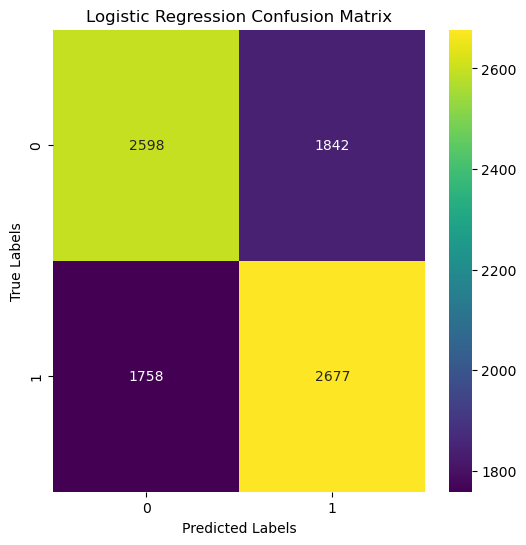

In [29]:
predictions = cross_val_predict(log_clf, X, y, cv=10)

# Confusion matrix
cm = confusion_matrix(y, predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

## Feature Importance
Let's find out which features are more important

In [30]:
import statsmodels.formula.api as smf

In [31]:
independent_vars = "+".join(df_train.columns.difference(["p1_won"]))
formula = "p1_won ~ " + independent_vars
log_reg = smf.logit(formula, data=df_train).fit()

Optimization terminated successfully.
         Current function value: 0.662889
         Iterations 5


In [32]:
# Summary of results
print(log_reg.summary())


                           Logit Regression Results                           
Dep. Variable:                 p1_won   No. Observations:                 7100
Model:                          Logit   Df Residuals:                     7085
Method:                           MLE   Df Model:                           14
Date:                Thu, 24 Aug 2023   Pseudo R-squ.:                 0.04362
Time:                        07:36:03   Log-Likelihood:                -4706.5
converged:                       True   LL-Null:                       -4921.2
Covariance Type:            nonrobust   LLR p-value:                 8.313e-83
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1613      1.109      0.145      0.884      -2.012       2.334
p1_age                 -1.5152      0.292     -5.192      0.000      -2.087      -0.943
p1_division     

## Decision Tree Model

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
DT_clf = DecisionTreeClassifier(random_state=0, max_depth=2)
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [35]:
# measure accuracy of the train set
predictions = DT_clf.predict(X_train)
dt_acc_train = sum(predictions == y_train)/len(predictions)
print("Decision Tree Accuracy on the Train data = %.2f%%" % (dt_acc_train*100))


Decision Tree Accuracy on the Train data = 55.08%


In [36]:
# measure accuracy of the test set
predictions = DT_clf.predict(X_test)
dt_acc_test = sum(predictions == y_test)/len(predictions)
print("Decision Tree: Test set Accuracy = %.3f%%" % (dt_acc_test*100))


Decision Tree: Test set Accuracy = 53.690%


### 10-fold Cross Validation
We will perform a 10-fold cross validation using the full data.

In [37]:
# Perform cross-validation and compute metrics
DT_clf = DecisionTreeClassifier(random_state=0, max_depth=10)
cv_results = cross_validate(DT_clf, X, y, cv=10, scoring=my_scorers)

# Extract the individual metric scores from cross-validation results
accuracies = cv_results['test_accuracy']
precisions = cv_results['test_precision']
recalls = cv_results['test_recall']
fscores = cv_results['test_f1_score']

# We have 10 scores for the 10 folds; take the mean
DT_accuracy = np.mean(accuracies)
DT_precision = np.mean(precisions)
DT_recall = np.mean(recalls)
DT_fscore = np.mean(fscores)

print("Accuracy:", np.round(DT_accuracy, 3))
print("Precision:", np.round(DT_precision, 3))
print("Recall:", np.round(DT_recall, 3))
print("F1-score:", np.round(DT_fscore, 3))


Accuracy: 0.55
Precision: 0.546
Recall: 0.589
F1-score: 0.566


### Hyper-parameter Tuning
We can tune for the hyper parameter, `max_depth`. That mean, we find the value of max_depth that gives the best cross validation f1 score.

In [38]:
max_depth_options = [2, 4, 6, 8, 10, 12, 14]
best_f1 = 0
best_depth = 0
for depth in max_depth_options:
    # Perform cross-validation and compute metrics
    DT_clf = DecisionTreeClassifier(random_state=0, max_depth=depth)
    cv_results = cross_validate(DT_clf, X, y, cv=10, scoring=my_scorers)
    
    # evaluate performance
    f1_score = np.mean(cv_results['test_f1_score'])
    print("Depth = %d, f1-score = %.2f"%(depth, f1_score))
    
    if f1_score > best_f1:
        best_f1 = f1_score
        best_depth = depth
        
print("\nBest depth value = %d\n"%(best_depth))


Depth = 2, f1-score = 0.42
Depth = 4, f1-score = 0.62
Depth = 6, f1-score = 0.56
Depth = 8, f1-score = 0.57
Depth = 10, f1-score = 0.57
Depth = 12, f1-score = 0.55
Depth = 14, f1-score = 0.54

Best depth value = 4



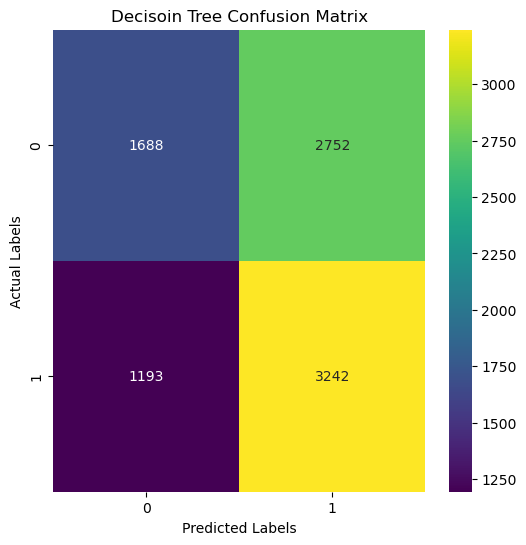

In [39]:
# Use the best 
DT_clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
predictions = cross_val_predict(DT_clf, X, y, cv=10)

# Compute the confusion matrix
cm = confusion_matrix(y, predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Decisoin Tree Confusion Matrix')
plt.show()

## Random Forest Model

In [40]:
from sklearn.ensemble import RandomForestClassifier


In [41]:
RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [42]:
# measure accuracy of the train set
predictions = RF_clf.predict(X_train)
rf_acc_train = sum(predictions == y_train)/len(predictions)
print("Random Forest Accuracy on the Train data = %.2f%%" % (rf_acc_train*100))


Random Forest Accuracy on the Train data = 57.76%


In [43]:
# measure accuracy of the test set
predictions = RF_clf.predict(X_test)
rf_acc_test = sum(predictions == y_test)/len(predictions)
print("Random Forest Accuracy on the Test data = %.2f%%" % (rf_acc_test*100))


Random Forest Accuracy on the Test data = 56.45%


### 10-fold Cross Validation
We will perform a 10-fold cross validation using the full data.

In [44]:
# Perform cross-validation and compute metrics
RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
cv_results = cross_validate(RF_clf, X, y, cv=10, scoring=my_scorers)

# Extract the individual metric scores from cross-validation results
accuracies = cv_results['test_accuracy']
precisions = cv_results['test_precision']
recalls = cv_results['test_recall']
fscores = cv_results['test_f1_score']

# We have 10 scores for the 10 folds; take the mean
RF_accuracy = np.mean(accuracies)
RF_precision = np.mean(precisions)
RF_recall = np.mean(recalls)
RF_fscore = np.mean(fscores)

print("Accuracy:", np.round(RF_accuracy, 3))
print("Precision:", np.round(RF_precision, 3))
print("Recall:", np.round(RF_recall, 3))
print("F1-score:", np.round(RF_fscore, 3))


Accuracy: 0.572
Precision: 0.566
Recall: 0.637
F1-score: 0.597


### Hyper-parameter Tuning
We can tune for the hyper parameter, `max_depth`. That mean, we find the value of max_depth that gives the best cross validation f1 score.

In [45]:
max_depth_options = [2, 4, 6, 8, 10, 12, 14]
best_f1 = 0
best_depth = 0
for depth in max_depth_options:
    # Perform cross-validation and compute metrics
    RF_clf = RandomForestClassifier(random_state=0, max_depth=depth)
    cv_results = cross_validate(RF_clf, X, y, cv=10, scoring=my_scorers)
    
    # evaluate performance
    f1_score = np.mean(cv_results['test_f1_score'])
    print("Depth = %d, f1-score = %.2f"%(depth, f1_score))
    
    if f1_score > best_f1:
        best_f1 = f1_score
        best_depth = depth
        
print("\nBest depth value = %d\n"%(best_depth))


Depth = 2, f1-score = 0.60
Depth = 4, f1-score = 0.60
Depth = 6, f1-score = 0.60
Depth = 8, f1-score = 0.59
Depth = 10, f1-score = 0.60
Depth = 12, f1-score = 0.59
Depth = 14, f1-score = 0.58

Best depth value = 6



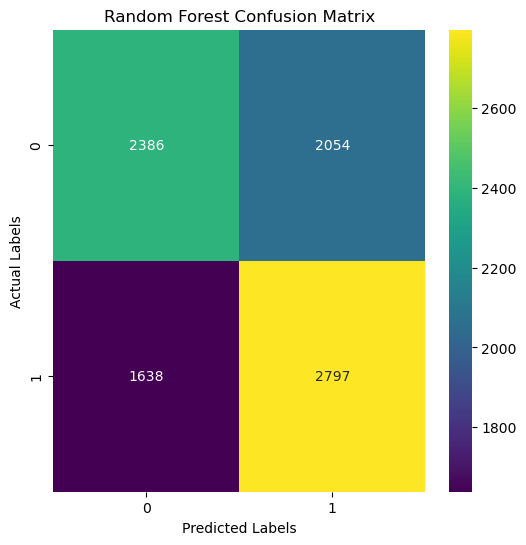

In [46]:
# Use the best 
RF_clf = RandomForestClassifier(random_state=0, max_depth=best_depth)
predictions = cross_val_predict(RF_clf, X, y, cv=10)

# Compute the confusion matrix
cm = confusion_matrix(y, predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

## kNN Classifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier


In [48]:
knn_clf = KNeighborsClassifier(n_neighbors=13)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=13)

In [49]:
# measure accuracy of the train set
predictions = knn_clf.predict(X_train)
knn_acc_train = sum(predictions == y_train)/len(predictions)
print("kNN Accuracy on the Train data = %.2f%%" % (knn_acc_train*100))


kNN Accuracy on the Train data = 65.41%


In [50]:
# measure accuracy of the test set
predictions = knn_clf.predict(X_test)
knn_acc_test = sum(predictions == y_test)/len(predictions)
print("kNN Accuracy on the Test data = %.2f%%" % (knn_acc_test*100))


kNN Accuracy on the Test data = 55.77%


### 10-fold Cross Validation
We will perform a 10-fold cross validation using the full data.

In [51]:
# Perform cross-validation and compute metrics
knn_clf = KNeighborsClassifier(n_neighbors=3)
cv_results = cross_validate(knn_clf, X, y, cv=10, scoring=my_scorers)

# Extract the individual metric scores from cross-validation results
accuracies = cv_results['test_accuracy']
precisions = cv_results['test_precision']
recalls = cv_results['test_recall']
fscores = cv_results['test_f1_score']

# We have 10 scores for the 10 folds; take the mean
knn_accuracy = np.mean(accuracies)
knn_precision = np.mean(precisions)
knn_recall = np.mean(recalls)
knn_fscore = np.mean(fscores)

print("Accuracy:", np.round(knn_accuracy, 3))
print("Precision:", np.round(knn_precision, 3))
print("Recall:", np.round(knn_recall, 3))
print("F1-score:", np.round(knn_fscore, 3))


Accuracy: 0.535
Precision: 0.535
Recall: 0.53
F1-score: 0.532


### Hyper-parameter Tuning
We can tune for the hyper parameter, `max_depth`. That mean, we find the value of max_depth that gives the best cross validation f1 score.

In [52]:
k_options = [3, 5, 7, 9, 11, 13, 15]
best_f1 = 0
best_k = 0
for k in k_options:
    # Perform cross-validation and compute metrics
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn_clf, X, y, cv=10, scoring=my_scorers)
    
    # evaluate performance
    f1_score = np.mean(cv_results['test_f1_score'])
    print("K = %d, f1-score = %.2f"%(k, f1_score))
    
    if f1_score > best_f1:
        best_f1 = f1_score
        best_k = k
        
print("\nBest k value = %d\n"%(best_k))


K = 3, f1-score = 0.53
K = 5, f1-score = 0.54
K = 7, f1-score = 0.54
K = 9, f1-score = 0.55
K = 11, f1-score = 0.56
K = 13, f1-score = 0.56
K = 15, f1-score = 0.56

Best k value = 15



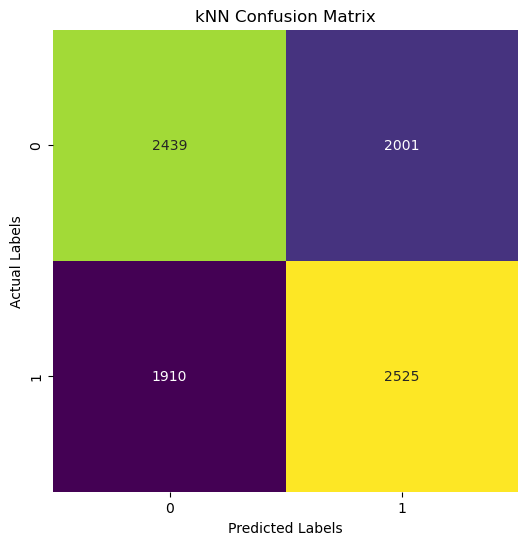

In [53]:
# Use the best 
knn_clf = KNeighborsClassifier(n_neighbors=best_k)
predictions = cross_val_predict(knn_clf, X, y, cv=10)

# Compute the confusion matrix
cm = confusion_matrix(y, predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('kNN Confusion Matrix')
plt.show()

## Comparison of Classifiers
Let's compare the Train, Test & Cross validation accuracies of different classifiers

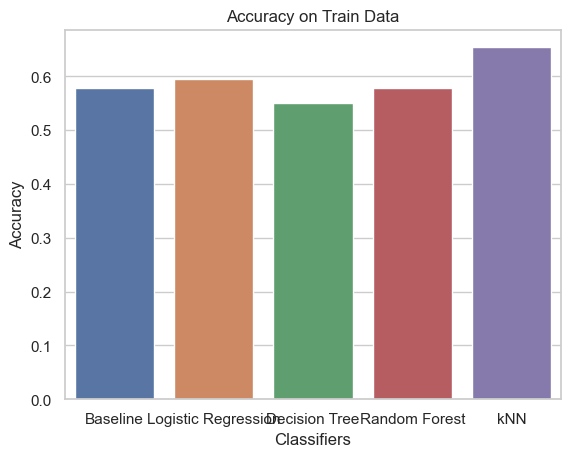

In [54]:
names = ['Baseline', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'kNN']
values = [baseline_acc_train, log_acc_train, dt_acc_train, rf_acc_train, knn_acc_train]

# Barplot
sns.set_theme(style="whitegrid")
sns.barplot(x=names, y=values)

# Set labels and title
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy on Train Data')

# Display the plot
plt.show()

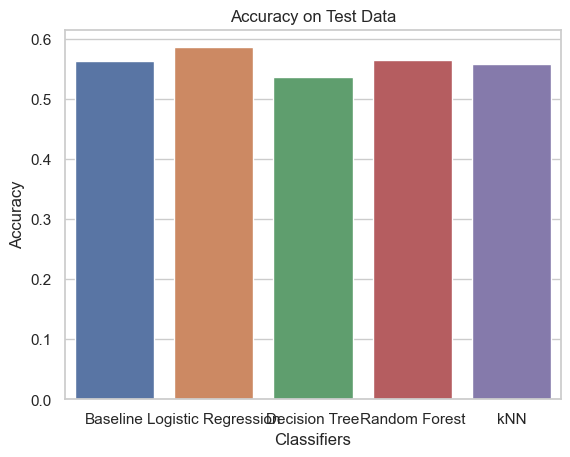

In [55]:
names = ['Baseline', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'kNN']
values = [baseline_acc_test, log_acc_test, dt_acc_test, rf_acc_test, knn_acc_test]

# Create a barplot using Seaborn
sns.barplot(x=names, y=values)

# Set labels and title
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy on Test Data')

# Display the plot
plt.show()

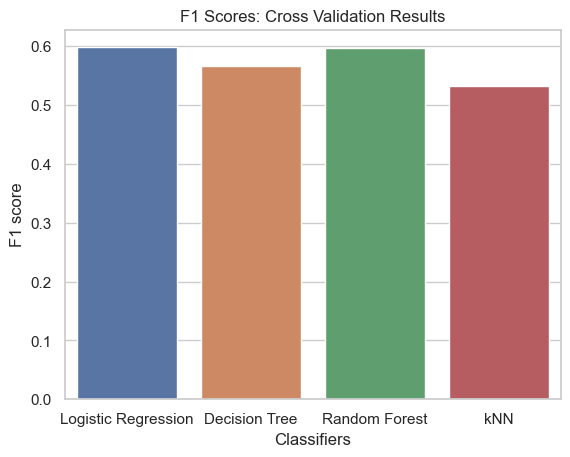

In [56]:
# Comparison of CV results (F1 Score)
names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'kNN']
values = [log_fscore, DT_fscore, RF_fscore, knn_fscore]

# Barplot
sns.set_theme(style="whitegrid")
sns.barplot(x=names, y=values)

# Set labels and title
plt.xlabel('Classifiers')
plt.ylabel('F1 score')
plt.title('F1 Scores: Cross Validation Results')

# Display the plot
plt.show()
